# **IP**

**Base-FSL**

Model successfully loaded on cuda
✅ Inference Time per Sample: 61.37 ms
Generating t-SNE plot...


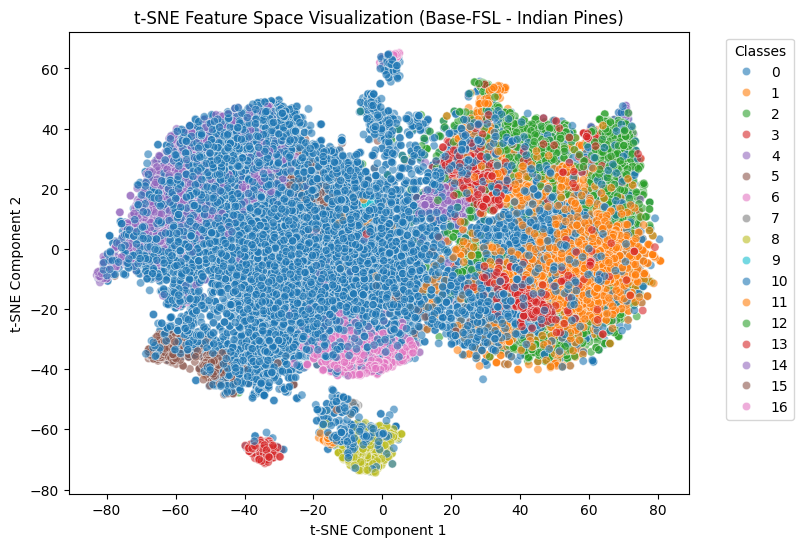

Generating UMAP plot...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


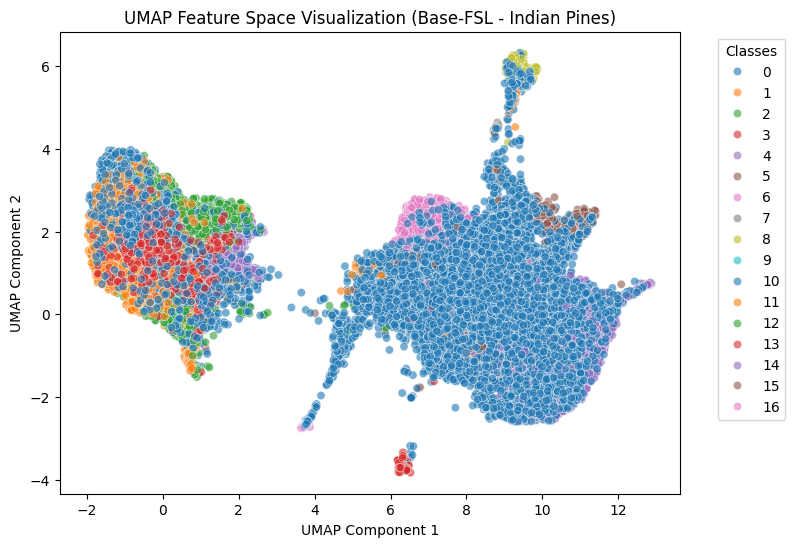

✅ Feature visualization complete!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import os

# ✅ Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 200, 128)  # Flattened feature output

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 200) -> (batch, 1, 200)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Ensure correct shape before computing distances
        query_embeddings = query_embeddings.view(-1, prototypes.shape[-1])

        dists = torch.cdist(query_embeddings, prototypes, p=2) ** 2
        return -dists

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "PrototypicalNetwork_IP.pth")
model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

print(f"Model successfully loaded on {device}")

# ✅ Load & Process Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values  # Last column contains true labels

# ✅ Extract Features with the Pre-Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()
inference_time = (time.time() - start_inf) * 1000  # Convert to ms

print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")

# ✅ t-SNE Projection
print("Generating t-SNE plot...")
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (Base-FSL - Indian Pines)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# ✅ UMAP Projection
print("Generating UMAP plot...")
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (Base-FSL - Indian Pines)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

print("✅ Feature visualization complete!")

**Aug-FSL**

Model successfully loaded on cuda
✅ Inference Time per Sample: 144.51 ms
Generating t-SNE plot...


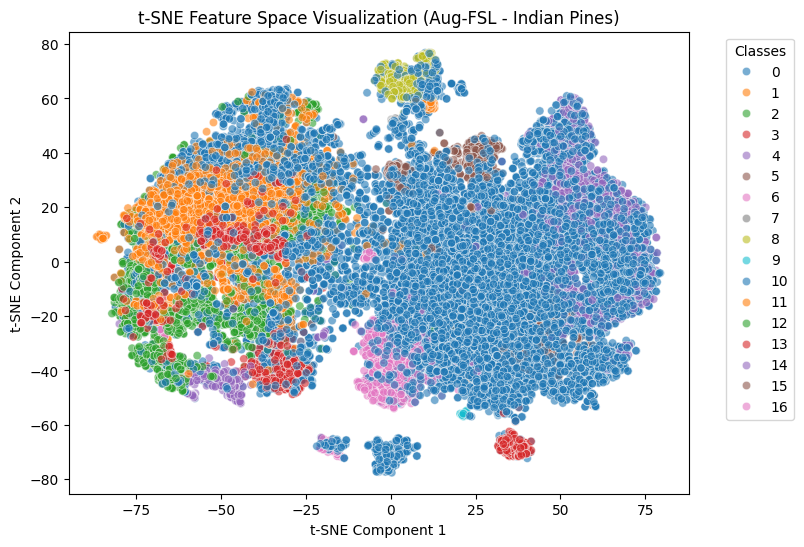

Generating UMAP plot...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


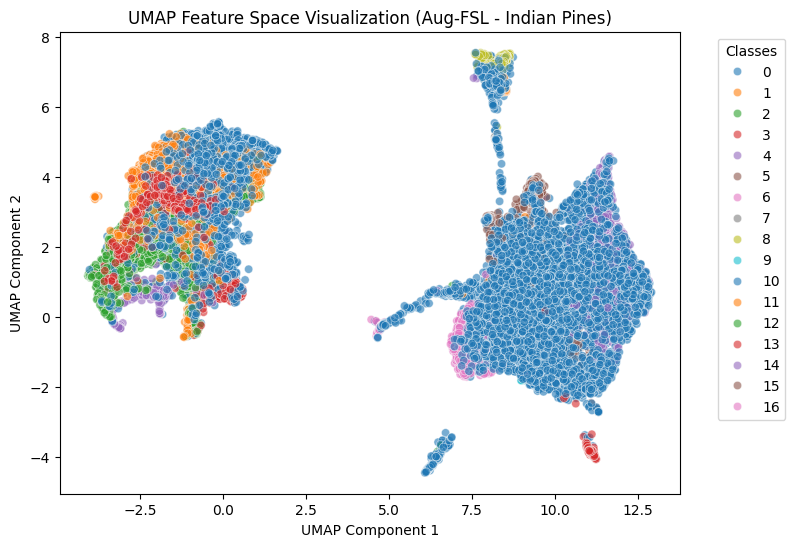

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import os

# ✅ Define Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self, input_dim):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 7, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc = nn.Linear(128 * input_dim, 256)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, input_dim):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor(input_dim)

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "Augmented_PrototypicalNetwork_IP.pth")

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Determine input dimension dynamically
input_dim = df_spectral.shape[1] - 1  # Exclude class column

# Initialize the model
model = PrototypicalNetwork(input_dim).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

print(f"Model successfully loaded on {device}")

# ✅ Load & Process Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values  # Last column contains true labels

# ✅ Extract Features with the Pre-Trained Model
start_inf = time.time()

# Extract Features using the trained model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()  # Convert to NumPy for classification

inference_time = (time.time() - start_inf) * 1000  # Convert to ms

print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")

# ✅ t-SNE Projection
print("Generating t-SNE plot...")
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (Aug-FSL - Indian Pines)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# ✅ UMAP Projection
print("Generating UMAP plot...")
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (Aug-FSL - Indian Pines)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

**Cat-FSL**

In [ ]:
!pip install catboost

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
!pip uninstall -y numpy catboost
!pip install numpy catboost --upgrade

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl (98.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
!pip install --upgrade --force-reinstall pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.3 MB/s eta 0:00:00
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 33.1 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Succes

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 13.76 ms
0:	learn: 2.6104308	total: 19.6ms	remaining: 19.6s
50:	learn: 0.8606865	total: 894ms	remaining: 16.6s
100:	learn: 0.6224074	total: 1.76s	remaining: 15.6s
150:	learn: 0.5373952	total: 2.64s	remaining: 14.8s
200:	learn: 0.4972339	total: 3.5s	remaining: 13.9s
250:	learn: 0.4722195	total: 4.37s	remaining: 13.1s
300:	learn: 0.4535489	total: 5.25s	remaining: 12.2s
350:	learn: 0.4378320	total: 6.13s	remaining: 11.3s
400:	learn: 0.4250302	total: 7s	remaining: 10.5s
450:	learn: 0.4132478	total: 7.87s	remaining: 9.58s
500:	learn: 0.4026349	total: 8.73s	remaining: 8.7s
550:	learn: 0.3925988	total: 9.6s	remaining: 7.83s
600:	learn: 0.3835130	total: 10.5s	remaining: 6.95s
650:	learn: 0.3749525	total: 11.3s	remaining: 6.08s
700:	learn: 0.3667394	total: 12.2s	remaining: 5.21s
750:	learn: 0.3588779	total: 13.1s	remaining: 4.33s
800:	learn: 0.3513992	total: 13.9s	remaining: 3.46s
850:	learn: 0.3443479	total: 14

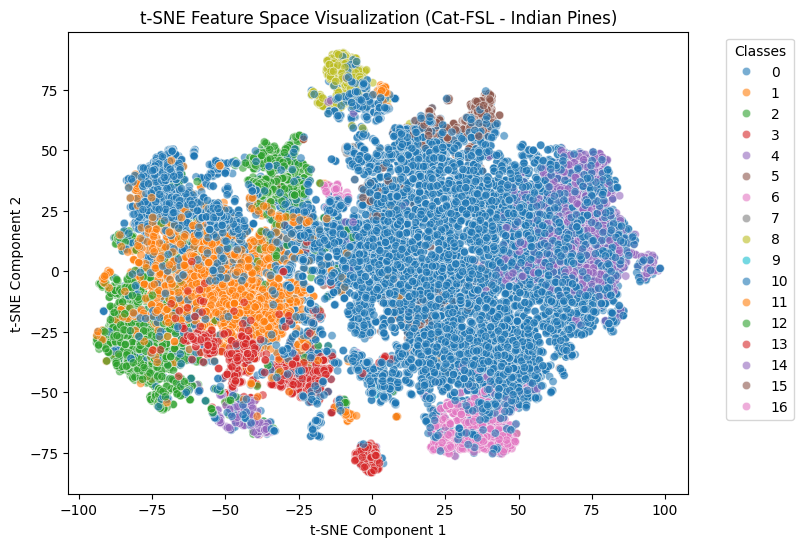

Generating UMAP plot...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


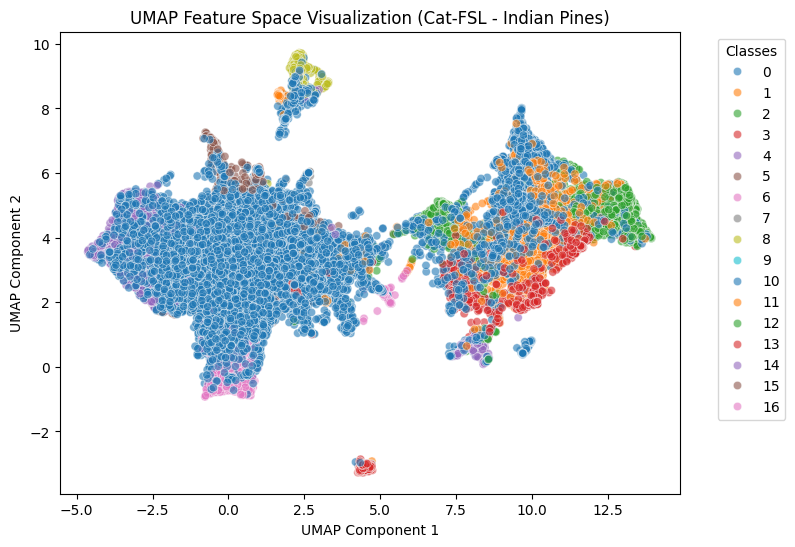

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from catboost import CatBoostClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.manifold import TSNE
import umap


# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.flattened_size = 256 * 200
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -1].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

# ✅ t-SNE Projection
print("Generating t-SNE plot...")
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(deep_features)  # Changed from embeddings to deep_features
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (Cat-FSL - Indian Pines)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# ✅ UMAP Projection
print("Generating UMAP plot...")
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(deep_features)  # Changed from embeddings to deep_features
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (Cat-FSL - Indian Pines)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

# **SALINAS**

**Base-FSL**

✅ Inference Time per Sample: 66.59 ms
Generating t-SNE plot...


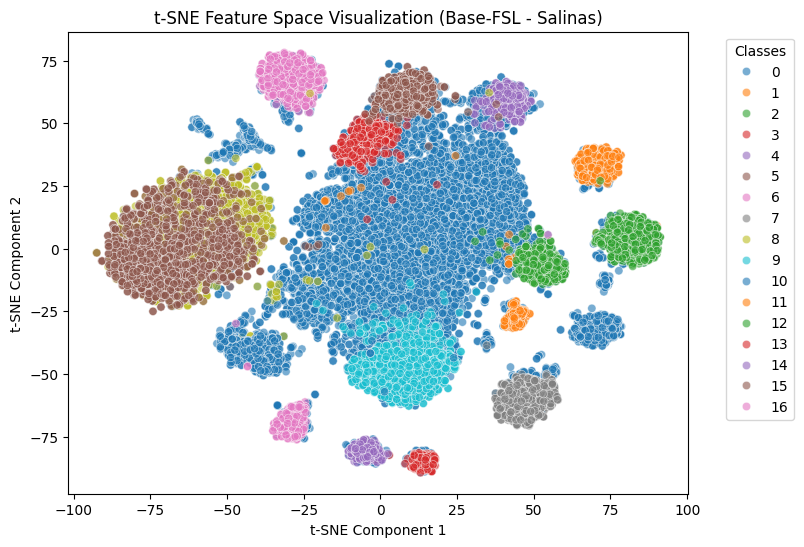

Generating UMAP plot...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


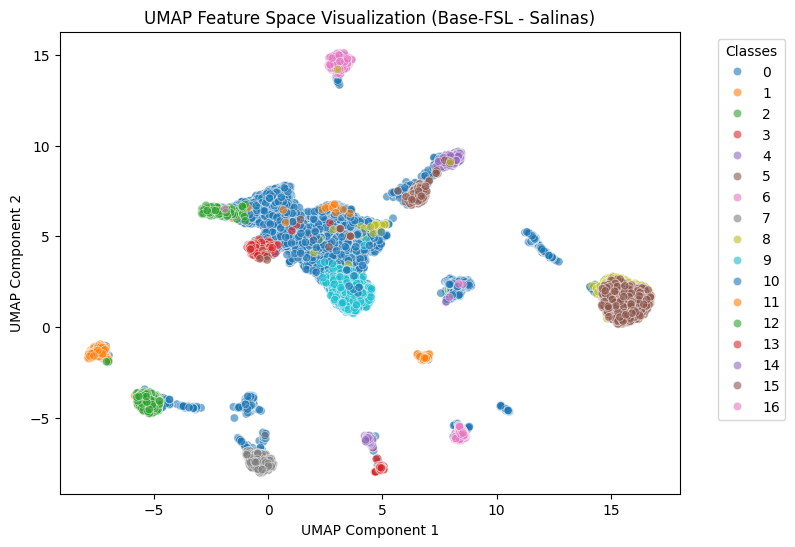

✅ Feature visualization complete!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import os

# Define Spectral Feature Extractor (1D CNN)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super(SpectralFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * 204, 128)  # 204 spectral bands

    def forward(self, x):
        x = x.unsqueeze(1)  # Convert (batch, 204) -> (batch, 1, 204)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Define Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super(PrototypicalNetwork, self).__init__()
        self.feature_extractor = SpectralFeatureExtractor()

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "PrototypicalNetwork_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set model to evaluation mode

# ✅ Load & Process Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -4].values  # Last column contains true labels

# ✅ Extract Features with the Pre-Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()
inference_time = (time.time() - start_inf) * 1000  # Convert to ms

print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")

# ✅ t-SNE Projection
print("Generating t-SNE plot...")
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (Base-FSL - Salinas)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# ✅ UMAP Projection
print("Generating UMAP plot...")
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (Base-FSL - Salinas)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

print("✅ Feature visualization complete!")

**Aug-FSL**

Model successfully loaded on cuda
✅ Inference Time per Sample: 373.21 ms
Generating t-SNE plot...


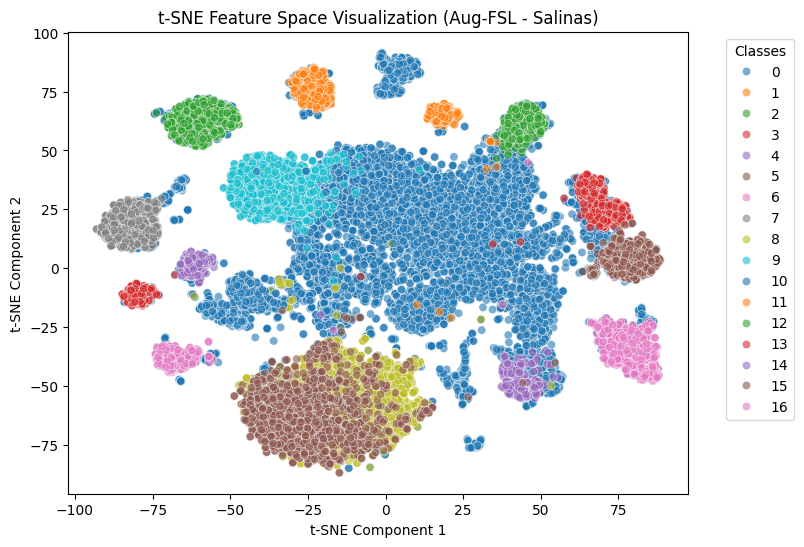

Generating UMAP plot...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


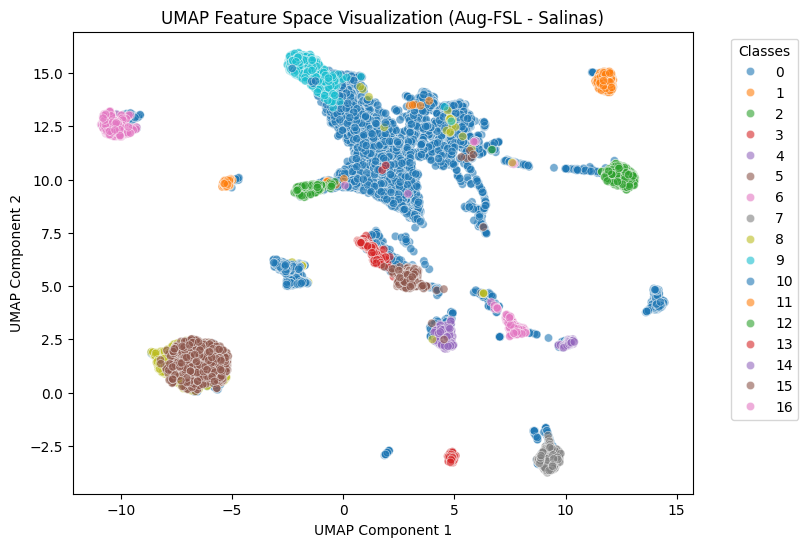

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
import os

# Improved Feature Extractor
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc = nn.Linear(256 * 204, 256)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Prototypical Network with Euclidean Distance
class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = SpectralFeatureExtractor()

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)

    def forward(self, support, query):
        support_embeddings = self.feature_extractor(support)
        query_embeddings = self.feature_extractor(query)
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)
        dists = self.euclidean_distance(query_embeddings, prototypes)
        return dists

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "Augmented_PrototypicalNetwork_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f"Model successfully loaded on {device}")

# ✅ Load & Process Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Reduced.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/Sal_sampled_gt.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -4].values  # Last column contains true labels

# ✅ Extract Features with the Pre-Trained Model
start_inf = time.time()

# Extract Features using the trained model
with torch.no_grad():
    feature_extractor = model.feature_extractor
    embeddings = feature_extractor(X_tensor).cpu().numpy()  # Convert to NumPy for classification

inference_time = (time.time() - start_inf) * 1000  # Convert to ms

print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")

# ✅ t-SNE Projection
print("Generating t-SNE plot...")
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (Aug-FSL - Salinas)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# ✅ UMAP Projection
print("Generating UMAP plot...")
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(embeddings)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (Aug-FSL - Salinas)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

**Cat-FSL**

Using device: cuda
✅ Model successfully loaded on cuda
✅ Inference Time per Sample: 238.75 ms
0:	learn: 2.5433932	total: 33.7ms	remaining: 33.6s
50:	learn: 0.5818549	total: 1.21s	remaining: 22.6s
100:	learn: 0.3639454	total: 2.35s	remaining: 21s
150:	learn: 0.3048277	total: 3.45s	remaining: 19.4s
200:	learn: 0.2796902	total: 4.55s	remaining: 18.1s
250:	learn: 0.2662701	total: 5.64s	remaining: 16.8s
300:	learn: 0.2560155	total: 6.72s	remaining: 15.6s
350:	learn: 0.2482308	total: 7.81s	remaining: 14.4s
400:	learn: 0.2417039	total: 8.92s	remaining: 13.3s
450:	learn: 0.2357863	total: 10s	remaining: 12.2s
500:	learn: 0.2306661	total: 11.1s	remaining: 11.1s
550:	learn: 0.2258976	total: 12.2s	remaining: 9.97s
600:	learn: 0.2219235	total: 13.4s	remaining: 8.87s
650:	learn: 0.2180678	total: 14.5s	remaining: 7.75s
700:	learn: 0.2147322	total: 15.5s	remaining: 6.63s
750:	learn: 0.2114842	total: 16.7s	remaining: 5.52s
800:	learn: 0.2083152	total: 17.8s	remaining: 4.41s
850:	learn: 0.2053983	total:

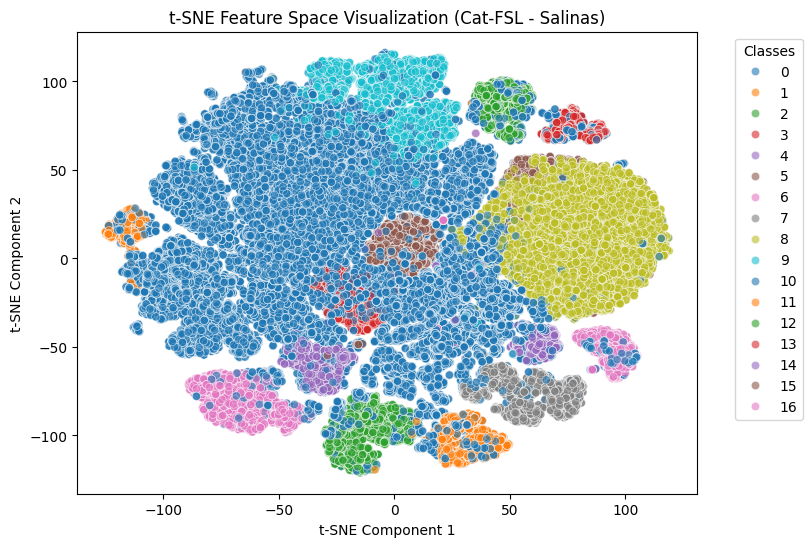

Generating UMAP plot...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


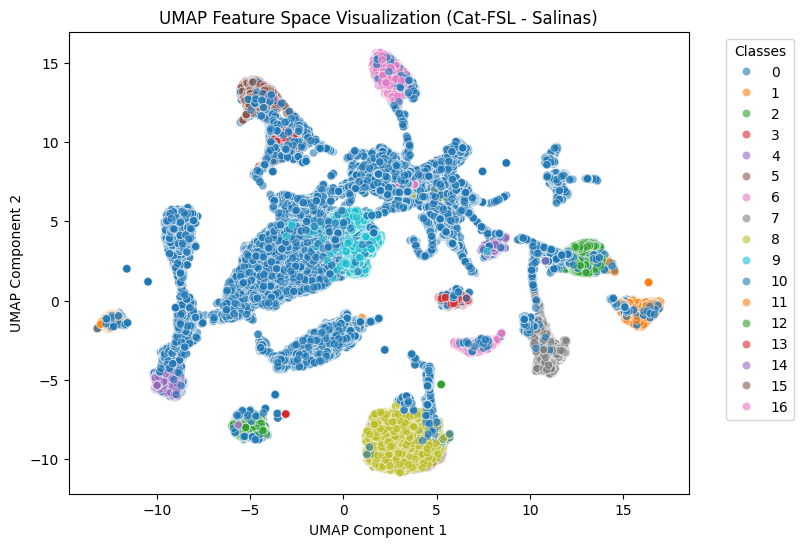

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score, adjusted_rand_score
from catboost import CatBoostClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.manifold import TSNE
import umap


# ✅ Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 204  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Prototypical Network for Few-Shot Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(204, 128, kernel_size=3, stride=1, padding=1),  # Changed 204 → 1
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# ✅ Load Trained Model
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_path = os.path.join(model_dir, "FS+CAT_Boost_Salinas.pth")

model = PrototypicalNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

print(f"✅ Model successfully loaded on {device}")

# ✅ Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(spectral_data_path)
X = df_spectral.iloc[:, :-1].values

# ✅ Normalize Data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
X_tensor = X_tensor.unsqueeze(1).transpose(1, 2)

# ✅ Load Ground Truth Labels
ground_truth_path = "/content/drive/MyDrive/Salinas_GT.csv"
df_gt = pd.read_csv(ground_truth_path)
y_ground_truth = df_gt.iloc[:, -2].values

# ✅ Extract Features using Trained Model
start_inf = time.time()
with torch.no_grad():
    feature_extractor = model.feature_extractor
    deep_features = feature_extractor(X_tensor).cpu().numpy()
# ✅ Compute Inference Time
inference_time = (time.time() - start_inf) * 1000  # Convert to ms
print(f"✅ Inference Time per Sample: {inference_time:.2f} ms")


# ✅ Train CatBoost on Deep Features
catboost_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    loss_function='MultiClass',
    task_type="GPU",
    verbose=50
)
catboost_model.fit(deep_features, y_ground_truth, verbose=50)

# ✅ Predict Using CatBoost
y_pred = catboost_model.predict(deep_features).flatten()

# ✅ t-SNE Projection
print("Generating t-SNE plot...")
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(deep_features)  # Changed from embeddings to deep_features
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Feature Space Visualization (Cat-FSL - Salinas)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# ✅ UMAP Projection
print("Generating UMAP plot...")
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_reducer.fit_transform(deep_features)  # Changed from embeddings to deep_features
plt.figure(figsize=(8, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=y_ground_truth, palette="tab10", alpha=0.6)
plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP Feature Space Visualization (Cat-FSL - Salinas)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()